# **Tweet emotion recognition**
This notebook shows the process and orientation in building a model to get an emotion expressed in tweet.

This notebook was created by: Ori Tabibi, Moran Lavi and Galina Reznik .

## Task 1: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7MB 30.6MB/s 
     |████████████████████████████████| 245kB 52.3MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


## Task 2: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
type(dataset)

nlp.dataset_dict.DatasetDict

In [6]:
train = dataset['train']
validation = dataset['validation']
test = dataset['test']

In [7]:
train

Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000)

In [8]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [9]:
train_tweets, train_labels = get_tweet(train)
valid_tweets, valid_labels = get_tweet(validation)
test_tweets, test_labels = get_tweet(test)

In [10]:
train_tweets[3], train_labels[3]

('i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'love')

## Task 3: Tokenizer

1. Tokenizing the tweets

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
import io
import json

num_words = get 10,000 words that are most common on out corpus (most frequantly words) <br>
oov_token = out of vocabulary token - the words that dont belong to the most commons will become tokenize as <unk> 

In [12]:
tokenizer = Tokenizer(num_words=10000,) #oov_token='<UNK>')
tokenizer.fit_on_texts(train_tweets)

In [13]:
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [14]:
print(train_tweets[10])
tokenizer.texts_to_sequences([train_tweets[3]])

i feel like i have to make the suffering i m seeing mean something


[[1, 23, 164, 7, 664, 26, 5, 4157, 1, 58, 46, 8, 12, 21, 71, 29, 5, 3496]]

unique tokens that not get into our corpus is 1

In [15]:
tokenizer.texts_to_sequences(['aaa']) # <unk>

[[]]

## Task 4: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

number of uniqe lenghts of tweets in our train set.<br>
most of the tweets are about 10-20 words long. <br>
very few tweets that are less than 3 words, very few longer than 50 words

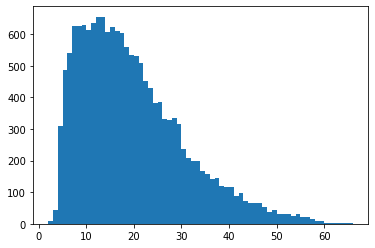

In [59]:
lengths = [len(t.split(' ')) for t in train_tweets] # how many words in each tweet
plt.hist(lengths, bins=len(set(lengths))) 
plt.show()

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 50

make all sequences the same input size for our model, len is 50

In [18]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets) # get all tweets as sequences (numbers that define each word)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [19]:
padded_train_seq = get_sequences(tokenizer, train_tweets) 

In [20]:
print(train_tweets[0])
print(train_labels[0])
padded_train_seq[0] # len is 50 words

i didnt feel humiliated
sadness


array([  1, 138,   2, 678,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 5: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

we have 6 classes : anger, fear, joy, sadness, surprise, love.

In [21]:
classes = ['anger', 'fear', 'joy', 'sadness', 'surprise', 'love']

number of tweets for our classes in out train set <br>
a lot of exapmles for sadness and joy, less for surprise <br>
class enbalace problem, but in this project we use data like this

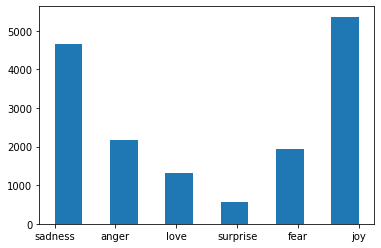

In [22]:
plt.hist(train_labels, bins=11)
plt.show()

convert the names of the classes to numeric value and vice versa

In [23]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k,v in class_to_index.items())

In [24]:
class_to_index

{'anger': 0, 'fear': 1, 'joy': 2, 'love': 5, 'sadness': 3, 'surprise': 4}

In [25]:
index_to_class

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness', 4: 'surprise', 5: 'love'}

In [26]:
names_to_ids = lambda train_labels: np.array([class_to_index.get(x) for x in train_labels])

In [27]:
train_labels_fix = names_to_ids(train_labels)
print(train_labels_fix[0])
print(index_to_class[train_labels_fix[0]])

3
sadness


## Task 6: EDA


1. number of tweets per class
2. word cloud of each class in the train set

In [ ]:
def count_classes(lst):
  class_cnt = {'sadness': 0,
               'anger' : 0,
               'love' : 0,
               'surprise' : 0,
               'fear' : 0,
               'joy' : 0,
                }
  for emotion in lst:
    class_cnt[emotion['label']] += 1
  return list(class_cnt.keys()), list(class_cnt.values())

def to_percent(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

def plot_graphs(values , labels, title):
  fig = plt.figure(figsize=(9, 6))
  plt.hist(labels, bins=11)
  plt.title(title)
  plt.show()

  k, v = count_classes(values)
  fig = plt.figure(figsize=(10, 7))
  plt.pie(v, labels=k, autopct = lambda pct: to_percent(pct, v),)
  plt.show()


number of tweets for our classes in out train set. <br>
a lot of exapmles for sadness and joy, less for surprise.

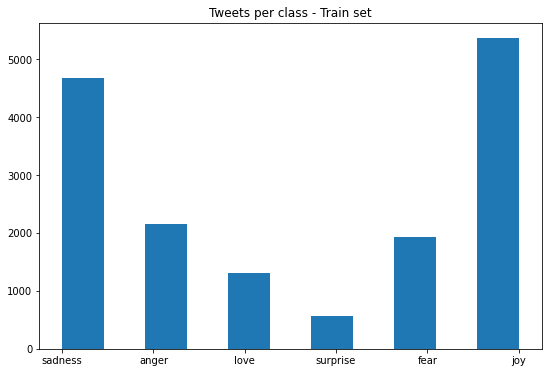

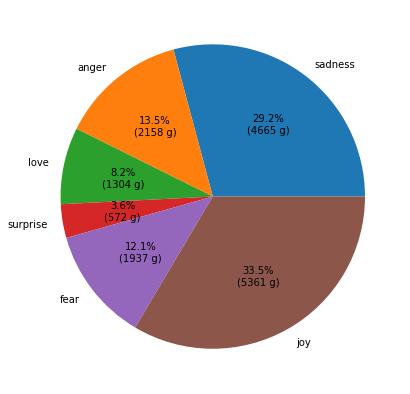

In [ ]:
plot_graphs(train, train_labels, "Tweets per class - Train set")

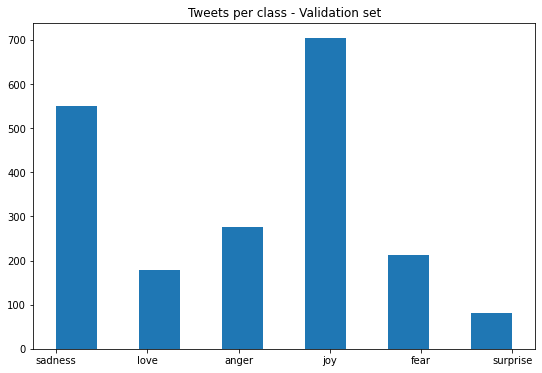

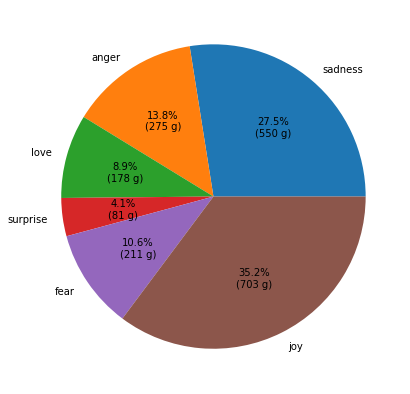

In [ ]:
plot_graphs(validation, valid_labels, "Tweets per class - Validation set")

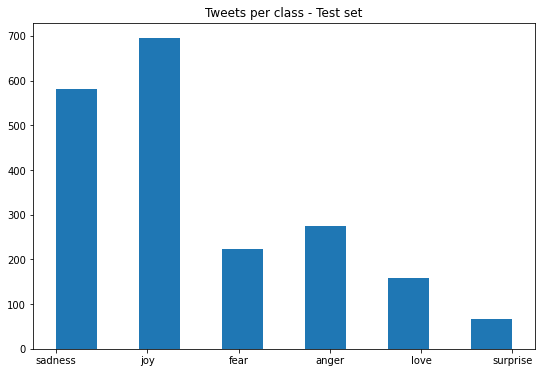

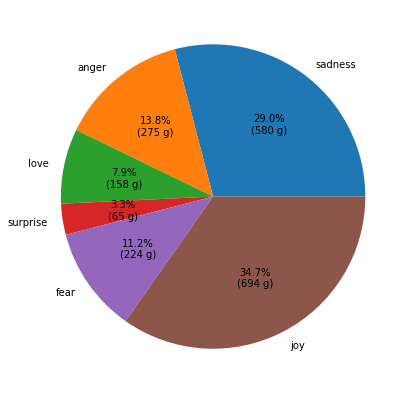

In [ ]:
plot_graphs(test, test_labels, "Tweets per class - Test set")

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.DataFrame.from_dict(train)
type(train_df)
train_df.head()

,label,text
0,sadness,i didnt feel humiliated
1,sadness,i can go from feeling so hopeless to so damned...
2,anger,im grabbing a minute to post i feel greedy wrong
3,love,i am ever feeling nostalgic about the fireplac...
4,anger,i am feeling grouchy


In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_word_cloud(df):
  wordcloud = WordCloud(stopwords=stopwords).generate(' '.join(train_df['text']))
  # Generate plot
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

def show_word_cloud_by_frequencies(d ,title=None):
  wordcloud = WordCloud(stopwords=stopwords).generate_from_frequencies(d)
  # Generate plot
  fig=plt.figure(figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')
  plt.imshow(wordcloud)
  plt.title(title)
  plt.axis("off")
  plt.show()

In [ ]:
import operator

def count_freq(string): 
  d = {}
  # count word frequencies
  for word in string.split(' '):
    if word in d.keys():
      d[word] += 1
    else:
      d[word] = 1
  return d

def create_dict_for_word_cloud(d, max, min):
  #sort frequencies
  d = dict(filter(lambda elem: elem[1] < max, d.items()))
  d = dict(filter(lambda elem: elem[1] > min, d.items()))
  return d


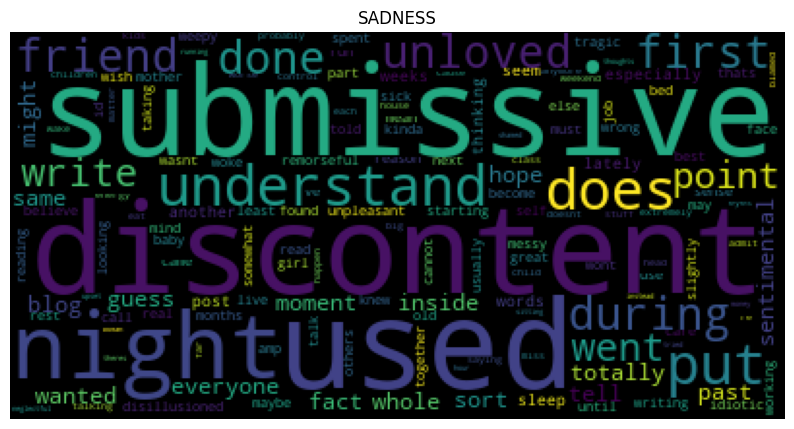

In [ ]:
w_string = ' '.join(train_df.loc[train_df['label']== 'sadness']['text'])
dic = count_freq(w_string)
dic = create_dict_for_word_cloud(dic, max=40, min=20)
show_word_cloud_by_frequencies(dic, 'SADNESS')

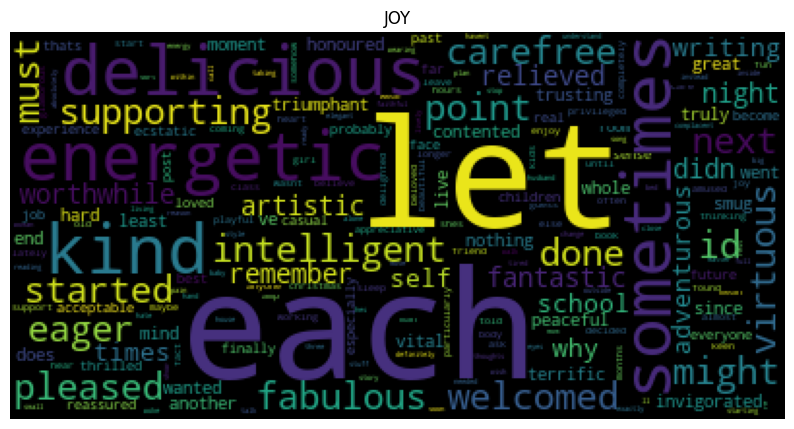

In [ ]:
w_string = ' '.join(train_df.loc[train_df['label']== 'joy']['text'])
dic = count_freq(w_string)
dic = create_dict_for_word_cloud(dic, max=50, min=10)
show_word_cloud_by_frequencies(dic, 'JOY')

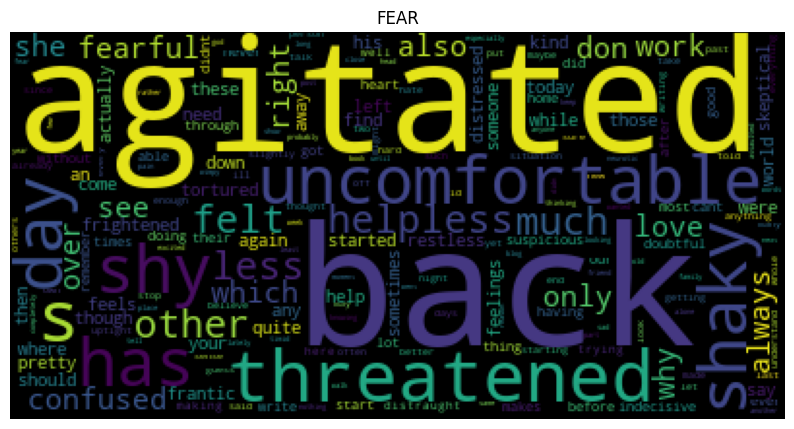

In [ ]:
w_string = ' '.join(train_df.loc[train_df['label']== 'fear']['text'])
dic = count_freq(w_string)
dic = create_dict_for_word_cloud(dic, max=50, min=10)
show_word_cloud_by_frequencies(dic, 'FEAR')

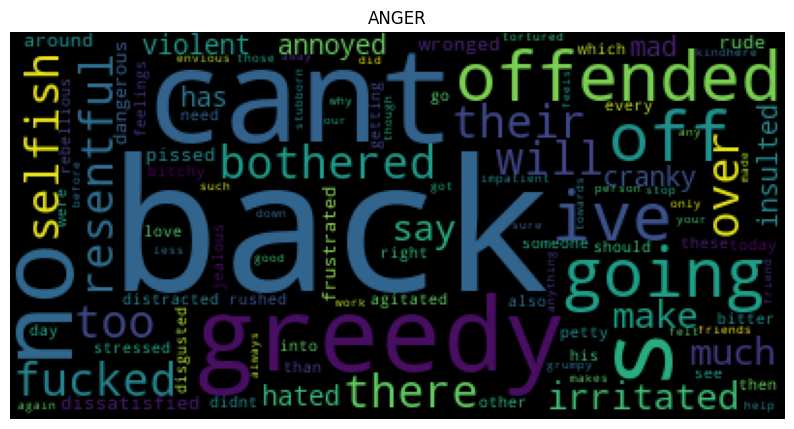

In [ ]:
w_string = ' '.join(train_df.loc[train_df['label']== 'anger']['text'])
dic = count_freq(w_string)
dic = create_dict_for_word_cloud(dic, max=65, min=30)
show_word_cloud_by_frequencies(dic, 'ANGER')

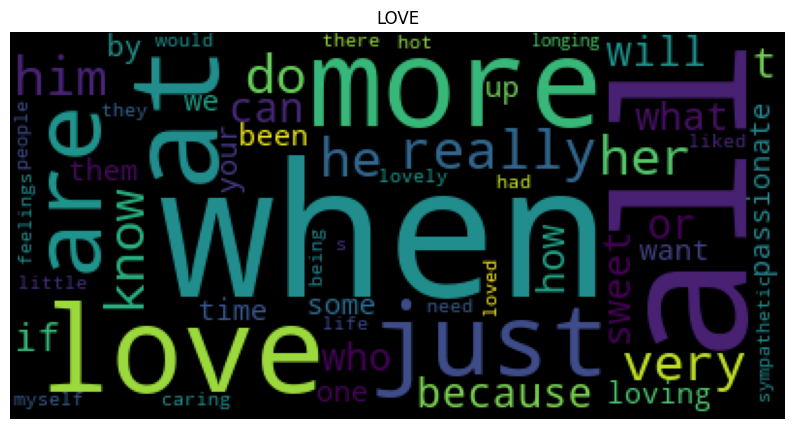

In [ ]:
w_string = ' '.join(train_df.loc[train_df['label']== 'love']['text'])
dic = count_freq(w_string)
dic = create_dict_for_word_cloud(dic, max=125, min=50)
show_word_cloud_by_frequencies(dic, 'LOVE')

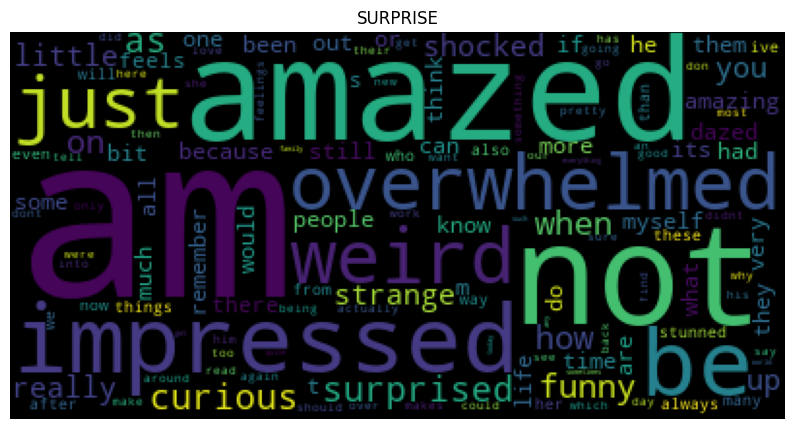

In [ ]:
w_string = ' '.join(train_df.loc[train_df['label']== 'surprise']['text'])
dic = count_freq(w_string)
dic = create_dict_for_word_cloud(dic, max=70, min=10)
show_word_cloud_by_frequencies(dic, 'SURPRISE')

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),  
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')                                   
])

model.compile( 
    loss = 'sparse_categorical_crossentropy',    # using sparse because our classes are not 1 hot encoded
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels = get_tweet(validation)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0], index_to_class[val_labels[0]]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 3,
 'sadness')

In [ ]:
train_labels_fix

array([3, 3, 0, ..., 2, 0, 3])

In [ ]:
h = model.fit(
    x=padded_train_seq,
    y=train_labels_fix,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2) # if we have no improvment after 2 epochs on val set the model will stop training
    ]
)

Epoch 1/20
500/500 [==============================] - 36s 61ms/step - loss: 1.3964 - accuracy: 0.4306 - val_loss: 0.8592 - val_accuracy: 0.6775
Epoch 2/20
500/500 [==============================] - 28s 57ms/step - loss: 0.6438 - accuracy: 0.7634 - val_loss: 0.6005 - val_accuracy: 0.7965
Epoch 3/20
500/500 [==============================] - 29s 58ms/step - loss: 0.3855 - accuracy: 0.8713 - val_loss: 0.5237 - val_accuracy: 0.8265
Epoch 4/20
500/500 [==============================] - 29s 57ms/step - loss: 0.2686 - accuracy: 0.9112 - val_loss: 0.4635 - val_accuracy: 0.8545
Epoch 5/20
500/500 [==============================] - 29s 57ms/step - loss: 0.1894 - accuracy: 0.9396 - val_loss: 0.4213 - val_accuracy: 0.8705
Epoch 6/20
500/500 [==============================] - 29s 57ms/step - loss: 0.1413 - accuracy: 0.9553 - val_loss: 0.4090 - val_accuracy: 0.8790
Epoch 7/20
500/500 [==============================] - 29s 57ms/step - loss: 0.1103 - accuracy: 0.9654 - val_loss: 0.4081 - val_accuracy:

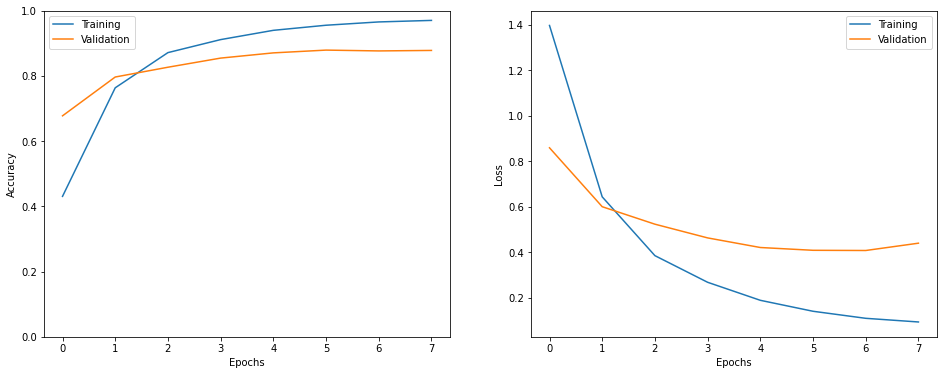

In [ ]:
show_history(h)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/MyDrive/Tweets_Emotion/Tweet_Emotion_model_no_uniqe.h5')

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Tweets_Emotion/Tweet_Emotion_model_no_uniqe.h5')

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)
print(len(test_labels))

2000


In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 3s 20ms/step - loss: 0.3967 - accuracy: 0.8850


In [ ]:
prediction = np.argmax(model.predict(test_seq),axis  =  1)

In [ ]:
print(prediction[0])
print(test_labels[0])

3
3


In [ ]:
from sklearn import metrics
print(metrics.classification_report(prediction, test_labels))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       267
           1       0.84      0.85      0.84       221
           2       0.89      0.95      0.92       655
           3       0.94      0.91      0.92       605
           4       0.65      0.66      0.66        65
           5       0.85      0.72      0.78       187

    accuracy                           0.89      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.89      0.89      0.88      2000



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


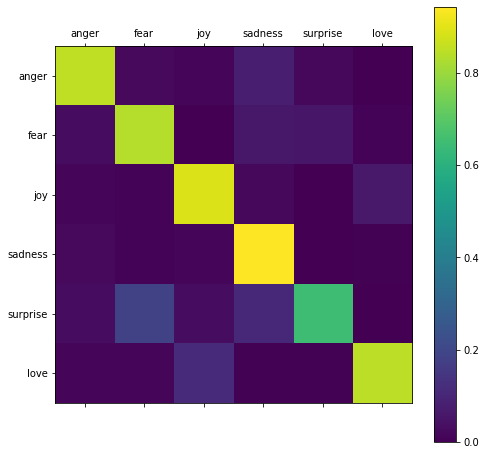

In [ ]:
test_predictions = model.predict_classes(test_seq)
show_confusion_matrix(test_labels, test_predictions, list(classes))

In [ ]:
for j in range(5):
    i = random.randint(0, len(test_labels) - 1)
    print('Tweet: ', test_tweets[i])
    print('Original emotion: ', index_to_class[test_labels[i]])
    pred = model.predict(np.expand_dims(test_seq[i], axis=0))[0] # expand dim to make the input shape correct to only 1 tweet
    pred_class = index_to_class[np.argmax(pred).astype('uint8')]
    print('Predicted emotion: ', pred_class)
    print()

Tweet:  i left my garmin on my bike so i was going to have to do this by feel coming out of transition its amazing hearing cheers and your adrenaline is just going crazy
Original emotion:  joy
Predicted emotion:  joy

Tweet:  i started to feel so overwhelmed
Original emotion:  fear
Predicted emotion:  surprise

Tweet:  i have so much going on in my life and am constantly running like crazy i can always steal a quiet moment to acknowledge this child and the overwhelming excitement and anticipation that i feel god is truly faithful and brings everything around
Original emotion:  love
Predicted emotion:  love

Tweet:  i feel like it was a bit of divine intervention for me
Original emotion:  joy
Predicted emotion:  joy

Tweet:  ive ever read that explains why i feel this way all the time and reassures me that im not just defective somehow
Original emotion:  sadness
Predicted emotion:  sadness



## Task 10: Scraping
1. install twint
2. use search word to scrap 100 tweets
3. clean and process tweets
4. predict emotion and see Statistical analysis 


In [28]:
from google.colab import drive
drive.mount('/content/drive')
model = tf.keras.models.load_model('/content/drive/MyDrive/Tweets_Emotion/Tweet_Emotion_model_no_uniqe.h5')

Mounted at /content/drive


In [29]:
pip install emoji

     |████████████████████████████████| 133kB 33.3MB/s 


In [30]:
# pip install twint

import os
!pip install twint
!pip uninstall twint -y
!git clone --depth=1 https://github.com/twintproject/twint.git
%cd twint/
!pip3 install . -r requirements.txt
%cd ..

     |████████████████████████████████| 1.3MB 40.9MB/s 
     |████████████████████████████████| 266kB 52.7MB/s 
     |████████████████████████████████| 358kB 55.0MB/s 
     |████████████████████████████████| 143kB 55.0MB/s 
     |████████████████████████████████| 296kB 56.9MB/s 
     |████████████████████████████████| 296kB 52.8MB/s 
  Created wheel for twint: filename=twint-2.1.20-cp37-none-any.whl size=33929 sha256=c9e7c9955bdacea79381654481dabb77b983a3a94695b722a862590ccc1d8154
  Stored in directory: /root/.cache/pip/wheels/66/25/c7/855c1d896087ef84df6e6713b8adb073aff99af119450e1e4f
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp37-none-any.whl size=13501 sha256=cf7d24178e78a9f9d56b1e8d23890abe7a78c3b3a0fa4615094cacf0e1d25252
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
  Created wheel for googletransx: filename=googletransx-2.4.2-cp37-none-any.whl size=15970 sha256=0c31e5aa74961b3b058067b5a2a1f490c3

/content


In [31]:
import twint
import nest_asyncio
import pandas as pd
nest_asyncio.apply()

import re
import emoji

In [32]:
# Configure
c = twint.Config()
c.Search= 'happy' #Here, I am searching for tweets mentioning 'happy'. 
c.Lang = "en" #Searching tweets which are only english language. 
c.Store_json = True
c.Output = '../data.json'
c.Limit= 100 #I am scraping 100 tweets.

twint.run.Search(c)


1405463883754659844 2021-06-17 09:54:36 +0000 <CraigTribe2> Clearly, @coopuk are very happy to alienate a proportion of their customer base!🤷‍♂️
1405463882244653057 2021-06-17 09:54:36 +0000 <babiejmnie> Do you know what an endorsement advertisement include? The person verbally saying they use the airline and encouraging gp to use it. His ad says “happy bday jimin”, you guys are acting like the words slapped on there are “Jimin approves of this airline”
1405463880537542662 2021-06-17 09:54:36 +0000 <HAta__happy2510> @yamatyanyazo 僕にめっちゃ保険かけて殺して！ そしたらお金入るお
1405463879426052097 2021-06-17 09:54:35 +0000 <AjayTiwariAj1> Happy birthday Sarika ji!♥️ @SarikaGupta1980 🎉  https://t.co/7DBweuH1IZ
1405463878956249090 2021-06-17 09:54:35 +0000 <weenterbear> @avrstllxx So sweeet. Happy birthday yaa
1405463877622681602 2021-06-17 09:54:35 +0000 <_oncelost> @TELLSTROUBLES || I would be more then happy to write with you.
1405463877148573700 2021-06-17 09:54:35 +0000 <eigetu_s> @yooo_oo_ ようすけさん😆💓 🎉🎂Hap

In [33]:
data = pd.read_json('../data.json', lines=True)
data = data.loc[lambda df: df['language'] == 'en'] # keep tweets in english
data

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1405463883754659844,1405463883754659840,2021-06-17 09:54:36+00:00,2021-06-17,09:54:36,0,1003692139056951298,craigtribe2,Craig Tribe 💙,,"Clearly, @coopuk are very happy to alienate a ...",en,"[{'screen_name': 'coopuk', 'name': 'co-op', 'i...",[],[],0,0,0,[],[],https://twitter.com/CraigTribe2/status/1405463...,False,https://twitter.com/we_make_ripples/status/140...,0,,,,,,,,[],,,,
1,1405463882244653057,1405463882244653056,2021-06-17 09:54:36+00:00,2021-06-17,09:54:36,0,1192374206823948289,babiejmnie,h¹³ ♡,,Do you know what an endorsement advertisement ...,en,[],[],[],0,0,0,[],[],https://twitter.com/babiejmnie/status/14054638...,False,https://twitter.com/house0fbangtan/status/1405...,0,,,,,,,,[],,,,
3,1405463879426052097,1405463879426052096,2021-06-17 09:54:35+00:00,2021-06-17,09:54:35,0,879756113264201729,ajaytiwariaj1,AjayTiwariAj,,Happy birthday Sarika ji!♥️ @SarikaGupta1980 🎉...,en,"[{'screen_name': 'sarikagupta1980', 'name': 's...",[],[https://pbs.twimg.com/media/E4E18xLVoAIrkco.jpg],0,0,0,[],[],https://twitter.com/AjayTiwariAj1/status/14054...,False,,1,https://pbs.twimg.com/media/E4E18xLVoAIrkco.jpg,,,,,,,[],,,,
4,1405463878956249090,1405463226679128064,2021-06-17 09:54:35+00:00,2021-06-17,09:54:35,0,1344527732634312704,weenterbear,in⁷,,@avrstllxx So sweeet. Happy birthday yaa,en,[],[],[],0,0,0,[],[],https://twitter.com/weenterbear/status/1405463...,False,,0,,,,,,,,"[{'screen_name': 'avrstllxx', 'name': '𝚗𝚒𝚜𝚢𝚒𝚎𝚎...",,,,
5,1405463877622681602,1405459735378206720,2021-06-17 09:54:35+00:00,2021-06-17,09:54:35,0,1240785376995917824,_oncelost,𝘓𝘪𝘭𝘺 𝘚𝘰𝘭𝘰𝘮𝘰𝘯𝘴. ✨,,@TELLSTROUBLES || I would be more then happy t...,en,[],[],[],0,0,0,[],[],https://twitter.com/_oncelost/status/140546387...,False,,0,,,,,,,,"[{'screen_name': 'TELLSTROUBLES', 'name': 'THO...",,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1405463822417027075,1405463822417027072,2021-06-17 09:54:22+00:00,2021-06-17,09:54:22,0,1351057498443284480,kimchin1608,chin⁷🌺 || semi-ia 🤍,,HAPPY 200 DAYS ENHYPEN!!!🥳🤍 https://t.co/IiFX...,en,[],[],[https://pbs.twimg.com/media/E4E15ZoUYAEqoMg.jpg],0,0,0,[],[],https://twitter.com/kimchin1608/status/1405463...,False,,1,https://pbs.twimg.com/media/E4E15ZoUYAEqoMg.jpg,,,,,,,[],,,,
96,1405463822291419138,1405463822291419136,2021-06-17 09:54:22+00:00,2021-06-17,09:54:22,0,4767538170,kitsuneanput,Emmeline Virago Rogan-Lomas,,We're dating OK YES AM HAPPY GAY YES https:/...,en,[],[],[https://pbs.twimg.com/media/E4E15djXwAUxgDk.jpg],0,0,0,[],[],https://twitter.com/KitsuneAnput/status/140546...,False,https://twitter.com/yumewithyou/status/1405079...,1,https://pbs.twimg.com/media/E4E15djXwAUxgDk.jpg,,,,,,,[],,,,
97,1405463822245187588,1405463061255835648,2021-06-17 09:54:22+00:00,2021-06-17,09:54:22,0,1259945542160912385,no_frankly,where does this highway go to?,,Trying to buy from an artist's web store. I ca...,en,[],[],[],0,0,0,[],[],https://twitter.com/no_frankly/status/14054638...,False,,0,,,,,,,,[],,,,
98,1405463821918035969,1405375561183031296,2021-06-17 09:54:22+00:00,2021-06-17,09:54:22,0,4317626292,sharkymist,SharkyMist🦈,,@notglutz Happy birthday! https://t.co/tGzLhD...,en,[],[],[https://pbs.twimg.com/tweet_video_thumb/E4E12...,0,0,0,[],[],https://twitter.com/SharkyMist/status/14054638...,False,,1,https://pbs.twimg.com/tweet_video_thumb/E4E12n...,,,,,,,"[{'screen_name': 'notglutz', 'name': 'Bday Boy...",,,,


In [34]:
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = emoji.get_emoji_regexp().sub(u'', tweet) # remove emojis from text
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = tweet.lower() # upper case to lower case
    tweet = ''.join([i for i in tweet if not i.isdigit()]) # remove digits
    return " ".join(tweet.split())

data['tweet'] = data['tweet'].map(lambda x: cleaner(x))

In [35]:
pd.options.display.max_columns = 100
t = data['tweet'][3]
print(t)
t_seq = get_sequences(tokenizer, [t])
print(t_seq)

happy birthday sarika ji!️
[[ 153 1241 6442    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


In [36]:
# predict emotion for tweet
print('Tweet: ', t)
pred = model.predict(t_seq)[0] # expand dim to make the input shape correct to only 1 tweet
pred_class = index_to_class[np.argmax(pred).astype('uint8')]
print('Predicted emotion: ', pred_class)
print()

Tweet:  happy birthday sarika ji!️
Predicted emotion:  joy



In [37]:
data.reset_index(drop=True, inplace=True)
scraped_tweets = []
for i in range(data.shape[0]):
  scraped_tweets.append(data['tweet'][i])
len(scraped_tweets)

81

In [39]:
scraped_tweets_seq = get_sequences(tokenizer, scraped_tweets)

In [40]:
classes = ['anger', 'fear', 'joy', 'sadness', 'surprise', 'love']
count_predictions_dict = dict((k,0) for k in classes)

In [41]:
scraped_tweets_seq = get_sequences(tokenizer, scraped_tweets)
for i in range(len(scraped_tweets_seq)):
    print('Tweet: ', scraped_tweets[i])
    pred = model.predict(np.expand_dims(scraped_tweets_seq[i], axis=0))[0] # expand dim to make the input shape correct to only 1 tweet
    pred_class = index_to_class[np.argmax(pred).astype('uint8')]
    print('Predicted emotion: ', pred_class)
    count_predictions_dict[pred_class] += 1
    print()

Tweet:  clearly, are very happy to alienate a proportion of their customer base!
Predicted emotion:  love

Tweet:  do you know what an endorsement advertisement include? the person verbally saying they use the airline and encouraging gp to use it. his ad says “happy bday jimin”, you guys are acting like the words slapped on there are “jimin approves of this airline”
Predicted emotion:  love

Tweet:  happy birthday sarika ji!️
Predicted emotion:  joy

Tweet:  so sweeet. happy birthday yaa
Predicted emotion:  anger

Tweet:  || i would be more then happy to write with you.
Predicted emotion:  joy

Tweet:  hi anujit, we're happy to help! visit to open a saving account with us! once you have filled up the form, we'll call you to assist further. -anay
Predicted emotion:  sadness

Tweet:  so far happy with the progress of our pawpaw project.. new green leaves don't forget we still have ready to plant pawpaw seedlings and passion fruit seedlings +
Predicted emotion:  love

Tweet:  happy birthd

In [42]:
count_predictions_dict

{'anger': 8, 'fear': 2, 'joy': 52, 'love': 7, 'sadness': 11, 'surprise': 1}

In [55]:
def get_pie_chart(count_dict: dict):
    """create pie chart from dictionary, labels is keys, data is values"""
    labels = count_dict.keys()
    sizes = count_dict.values()
    explode = (0.1, 0.1, 0.1, 0.1, 0.2, 0.1)

    fig1 = plt.figure(figsize=(11,8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', explode=explode)

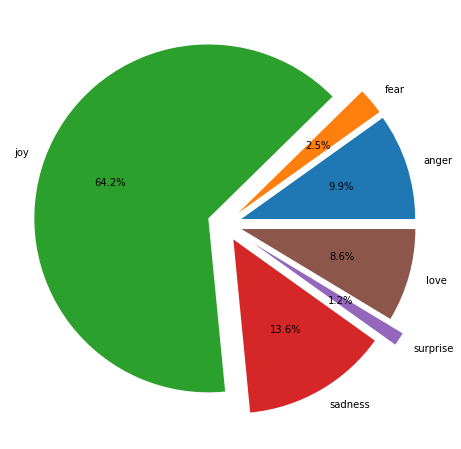

In [56]:
get_pie_chart(count_predictions_dict)

## Conclusions:

1. we had a class enbalace problem that we didnt fixed, but still the model get high results. <br>
2. twint is a very powerfull tool to scrap tweets quickly and easly. <br>
3. clean tweets correctly is very important step to get better results. <br>
4. get emotion from tweets is a task that can be done with good results.

## future work:
1. train the model to also recognize emojis because it is a good way to predict a emotion from tweet.
2. try to improve our model to get even better results or examine the possibility of using other models. 
